# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Plots
using StatsBase
using Distances

include("../../lib.jl")

ENV["LINES"]=30;

# Datasets

In [2]:
data = CSV.read("data.csv")

,Class_Name,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,String,Int64,Int64,Int64,Int64
1,B,1,1,1,1
2,R,1,1,1,2
3,R,1,1,1,3
4,R,1,1,1,4
5,R,1,1,1,5
6,R,1,1,2,1
7,R,1,1,2,2
8,R,1,1,2,3
9,R,1,1,2,4


Look at class labels to see if dataset is imbalanced

In [3]:
label_counts = countmap(data[:Class_Name])

Dict{String,Int64} with 3 entries:
  "B" => 49
  "L" => 288
  "R" => 288

In [4]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

3-element Array{Float64,1}:
 0.0784
 0.4608
 0.4608

Get data ready for training

In [5]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Class_Name,,B,,R,3,,String
2,Left_Weight,3.0,1,3.0,5,,,Int64
3,Left_Distance,3.0,1,3.0,5,,,Int64
4,Right_Weight,3.0,1,3.0,5,,,Int64
5,Right_Distance,3.0,1,3.0,5,,,Int64


In [6]:
coerce!(data, :Class_Name=>Multiclass,
              :Left_Weight=>Continuous,
              :Right_Weight=>Continuous,
              :Left_Distance=>Continuous,
              :Right_Distance=>Continuous)
schema(data)

┌────────────────┬─────────────────────────────────┬───────────────┐
│ _.names        │ _.types                         │ _.scitypes    │
├────────────────┼─────────────────────────────────┼───────────────┤
│ Class_Name     │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ Left_Weight    │ Float64                         │ Continuous    │
│ Left_Distance  │ Float64                         │ Continuous    │
│ Right_Weight   │ Float64                         │ Continuous    │
│ Right_Distance │ Float64                         │ Continuous    │
└────────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 625


In [7]:
y, X = unpack(data, ==(:Class_Name), colname->true)

(CategoricalValue{String,UInt32}["B", "R", "R", "R", "R", "R", "R", "R", "R", "R"  …  "L", "L", "L", "L", "L", "L", "L", "L", "L", "B"], 625×4 DataFrame
│ Row │ Left_Weight │ Left_Distance │ Right_Weight │ Right_Distance │
│     │ Float64     │ Float64       │ Float64      │ Float64        │
├─────┼─────────────┼───────────────┼──────────────┼────────────────┤
│ 1   │ 1.0         │ 1.0           │ 1.0          │ 1.0            │
│ 2   │ 1.0         │ 1.0           │ 1.0          │ 2.0            │
│ 3   │ 1.0         │ 1.0           │ 1.0          │ 3.0            │
│ 4   │ 1.0         │ 1.0           │ 1.0          │ 4.0            │
│ 5   │ 1.0         │ 1.0           │ 1.0          │ 5.0            │
│ 6   │ 1.0         │ 1.0           │ 2.0          │ 1.0            │
│ 7   │ 1.0         │ 1.0           │ 2.0          │ 2.0            │
│ 8   │ 1.0         │ 1.0           │ 2.0          │ 3.0            │
│ 9   │ 1.0         │ 1.0           │ 2.0          │ 4.0            │
│ 10  │

Partition train and test data accoring to class labels

In [67]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=111, stratify=values(data[:Class_Name])) # gives 70:30 split

([517, 192, 76, 304, 197, 593, 107, 463, 166, 425  …  68, 334, 268, 448, 407, 575, 69, 220, 167, 504], [516, 173, 615, 181, 52, 144, 238, 74, 372, 162  …  364, 22, 227, 384, 324, 54, 79, 277, 134, 600])

In [68]:
train_counts = countmap(data[train,:Class_Name])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.0776255707762557
 0.4611872146118721
 0.4611872146118721

In [69]:
test_counts = countmap(data[test,:Class_Name])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.08021390374331551
 0.45989304812834225
 0.45989304812834225

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [70]:
models(matching(X,y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [71]:
@load KNNClassifier

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @537

## K Nearest Neighbors
* Use different values of k.

1. https://alan-turing-institute.github.io/MLJ.jl/dev/composing_models/
1. https://github.com/KristofferC/NearestNeighbors.jl

In [72]:
knn = KNNClassifier(K=5)

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @565

In [73]:
KNN = machine(knn, X, y)

Machine{KNNClassifier} @776 trained 0 times.
  args: 
    1:	Source @859 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @184 ⏎ `AbstractArray{Multiclass{3},1}`


In [74]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @776.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{KNNClassifier} @776 trained 1 time.
  args: 
    1:	Source @859 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @184 ⏎ `AbstractArray{Multiclass{3},1}`


In [75]:
knn_acc = evaluate!(KNN, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬───────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                │
├───────────────┼───────────────┼───────────────────────────────────────────┤
│ cross_entropy │ 2.86          │ [2.99, 3.33, 3.7, 0.842, 2.65, 3.65]      │
│ acc           │ 0.819         │ [0.762, 0.817, 0.76, 0.913, 0.817, 0.846] │
└───────────────┴───────────────┴───────────────────────────────────────────┘
_.per_observation = [[[0.223, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [36.0, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 0.511], [2.22e-16, 2.22e-16, ..., 0.511], [2.22e-16, 2.22e-16, ..., 2.22e-16]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [76]:
fitted_params(KNN)

(tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{4},Float64,1,4},Euclidean,Float64}
  Number of points: 521
  Dimensions: 4
  Metric: Euclidean(0.0)
  Reordered: true,)

### GridSearch / RandomSearch

#### Euclidean

In [116]:
knn_grid = KNNClassifier()

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @286

In [117]:
param1 = :K

r1 = range(knn_grid, param1, lower=1, upper=9, scale=:linear)

MLJBase.NumericRange(Int64, :K, ... )

In [118]:
self_tuning_knn_model = TunedModel(model=knn_grid,
                                    tuning=Grid(goal=16),
                                    resampling=CV(nfolds=6, shuffle=true), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1],
                                    operation=predict_mode)

ProbabilisticTunedModel(
    model = KNNClassifier(
            K = 5,
            algorithm = :kdtree,
            metric = Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    tuning = Grid(
            goal = 16,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict_mode,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @291],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @015

In [119]:
self_tuning_knn = machine(self_tuning_knn_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @725 trained 0 times.
  args: 
    1:	Source @120 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @174 ⏎ `AbstractArray{Multiclass{3},1}`


In [120]:
z = fit!(self_tuning_knn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @725.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 9 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 9 metamodels: 100%[=========================] Time: 0:00:00


Machine{ProbabilisticTunedModel{Grid,…}} @725 trained 1 time.
  args: 
    1:	Source @120 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @174 ⏎ `AbstractArray{Multiclass{3},1}`


In [121]:
best = fitted_params(self_tuning_knn)
best

(best_model = KNNClassifier @491,
 best_fitted_params = (tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{4},Float64,1,4},Euclidean,Float64}
  Number of points: 438
  Dimensions: 4
  Metric: Euclidean(0.0)
  Reordered: true,),)

In [122]:
best.best_model

KNNClassifier(
    K = 9,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @491

**Learning Curves**

In [123]:
data_schedule, training_losses, valid_losses = learn_curve(best.best_model, X[train,:], y[train], acc)

(d, train_metric, valid_metric) = (10, 0.6, 0.38636363636363635)
(d, train_metric, valid_metric) = (15, 0.6, 0.5113636363636364)
(d, train_metric, valid_metric) = (20, 0.85, 0.6022727272727273)
(d, train_metric, valid_metric) = (25, 0.84, 0.625)
(d, train_metric, valid_metric) = (30, 0.7333333333333333, 0.5681818181818182)
(d, train_metric, valid_metric) = (35, 0.8571428571428571, 0.6818181818181818)
(d, train_metric, valid_metric) = (40, 0.9, 0.7272727272727273)
(d, train_metric, valid_metric) = (45, 0.8888888888888888, 0.7613636363636364)
(d, train_metric, valid_metric) = (50, 0.9, 0.7386363636363636)
(d, train_metric, valid_metric) = (55, 0.9090909090909091, 0.7727272727272727)
(d, train_metric, valid_metric) = (60, 0.9166666666666666, 0.7840909090909091)
(d, train_metric, valid_metric) = (65, 0.9076923076923077, 0.7954545454545454)
(d, train_metric, valid_metric) = (70, 0.9, 0.8068181818181818)
(d, train_metric, valid_metric) = (75, 0.88, 0.8068181818181818)
(d, train_metric, valid

(10:5:350, Any[0.6, 0.6, 0.85, 0.84, 0.7333333333333333, 0.8571428571428571, 0.9, 0.8888888888888888, 0.9, 0.9090909090909091  …  0.9081967213114754, 0.9193548387096774, 0.9111111111111111, 0.90625, 0.9015384615384615, 0.9090909090909091, 0.9104477611940298, 0.9205882352941176, 0.9159420289855073, 0.9114285714285715], Any[0.38636363636363635, 0.5113636363636364, 0.6022727272727273, 0.625, 0.5681818181818182, 0.6818181818181818, 0.7272727272727273, 0.7613636363636364, 0.7386363636363636, 0.7727272727272727  …  0.8636363636363636, 0.8522727272727273, 0.8522727272727273, 0.8522727272727273, 0.8522727272727273, 0.8522727272727273, 0.8636363636363636, 0.8636363636363636, 0.8863636363636364, 0.8522727272727273])

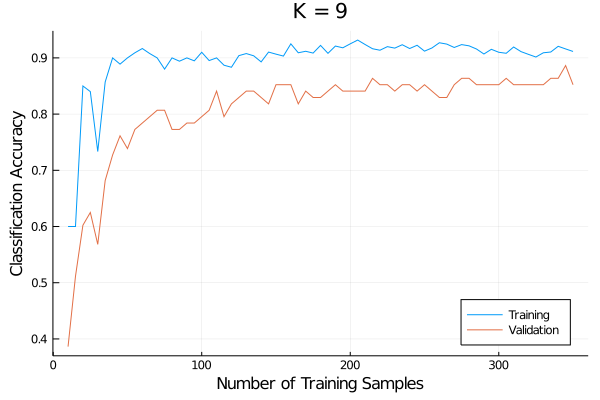

In [124]:
plot(data_schedule, training_losses, label="Training", legend=:bottomright)
plot!(data_schedule, valid_losses, label="Validation")
xlabel!("Number of Training Samples")
ylabel!("Classification Accuracy")
title!("K = $(best.best_model.K)")

In [125]:
fn = "Figures/KNN_LC"
png(replace(fn,'.' => ','))

In [126]:
self_tuning_knn.report.plotting

(parameter_names = ["K"],
 parameter_scales = [:linear],
 parameter_values = Any[5; 6; … ; 1; 4],
 measurements = [0.8356164383561645, 0.8698630136986302, 0.8995433789954337, 0.8310502283105023, 0.8835616438356163, 0.8744292237442922, 0.7625570776255709, 0.7876712328767125, 0.8264840182648404],)

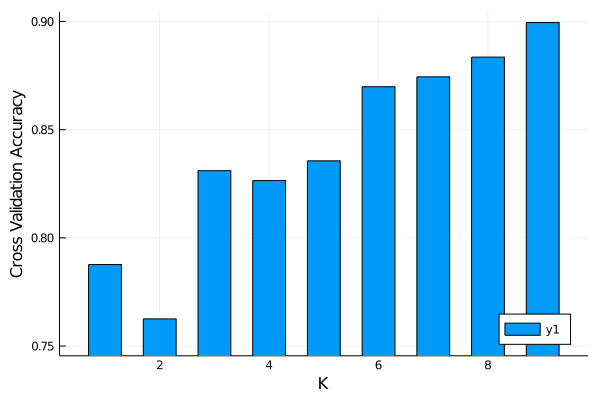

In [127]:
bar(self_tuning_knn.report.plotting.parameter_values[:,1], 
    self_tuning_knn.report.plotting.measurements,
    bar_width=0.6,
    ylims=[0.75, 0.9], legend=:bottomright)
xlabel!("K")
ylabel!("Cross Validation Accuracy")

In [128]:
fn = "Figures/KNN_MCC"
png(replace(fn,'.' => ','))

#### Manhattan

In [90]:
knn_grid = KNNClassifier(metric=Cityblock())

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Cityblock(),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @447

In [98]:
param1 = :K

r1 = range(knn_grid, param1, lower=1, upper=9, scale=:linear)

MLJBase.NumericRange(Int64, :K, ... )

In [99]:
self_tuning_knn_model = TunedModel(model=knn_grid,
                                    tuning=Grid(goal=15),
                                    resampling=CV(nfolds=6, shuffle=true), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1], 
                                    operation=predict_mode)

ProbabilisticTunedModel(
    model = KNNClassifier(
            K = 5,
            algorithm = :kdtree,
            metric = Cityblock(),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    tuning = Grid(
            goal = 15,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict_mode,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @291],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @471

In [100]:
self_tuning_knn = machine(self_tuning_knn_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @349 trained 0 times.
  args: 
    1:	Source @673 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @660 ⏎ `AbstractArray{Multiclass{3},1}`


In [101]:
z = fit!(self_tuning_knn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @349.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 9 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 9 metamodels: 100%[=========================] Time: 0:00:00


Machine{ProbabilisticTunedModel{Grid,…}} @349 trained 1 time.
  args: 
    1:	Source @673 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @660 ⏎ `AbstractArray{Multiclass{3},1}`


In [102]:
best_Man = fitted_params(self_tuning_knn)
best_Man

(best_model = KNNClassifier @163,
 best_fitted_params = (tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{4},Float64,1,4},Euclidean,Float64}
  Number of points: 438
  Dimensions: 4
  Metric: Euclidean(0.0)
  Reordered: true,),)

In [103]:
best_Man.best_model

KNNClassifier(
    K = 9,
    algorithm = :kdtree,
    metric = Cityblock(),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @163

**Learning Curves**

In [104]:
data_schedule, training_losses, valid_losses = learn_curve(best_Man.best_model, X[train,:], y[train], acc)

(d, train_metric, valid_metric) = (10, 0.6, 0.38636363636363635)
(d, train_metric, valid_metric) = (15, 0.6, 0.5113636363636364)
(d, train_metric, valid_metric) = (20, 0.85, 0.6022727272727273)
(d, train_metric, valid_metric) = (25, 0.84, 0.625)
(d, train_metric, valid_metric) = (30, 0.7333333333333333, 0.5681818181818182)
(d, train_metric, valid_metric) = (35, 0.8571428571428571, 0.6818181818181818)
(d, train_metric, valid_metric) = (40, 0.9, 0.7272727272727273)
(d, train_metric, valid_metric) = (45, 0.8888888888888888, 0.7613636363636364)
(d, train_metric, valid_metric) = (50, 0.9, 0.7386363636363636)
(d, train_metric, valid_metric) = (55, 0.9090909090909091, 0.7727272727272727)
(d, train_metric, valid_metric) = (60, 0.9166666666666666, 0.7840909090909091)
(d, train_metric, valid_metric) = (65, 0.9076923076923077, 0.7954545454545454)
(d, train_metric, valid_metric) = (70, 0.9, 0.8068181818181818)
(d, train_metric, valid_metric) = (75, 0.88, 0.8068181818181818)
(d, train_metric, valid

(10:5:350, Any[0.6, 0.6, 0.85, 0.84, 0.7333333333333333, 0.8571428571428571, 0.9, 0.8888888888888888, 0.9, 0.9090909090909091  …  0.9081967213114754, 0.9193548387096774, 0.9111111111111111, 0.90625, 0.9015384615384615, 0.9090909090909091, 0.9104477611940298, 0.9205882352941176, 0.9159420289855073, 0.9114285714285715], Any[0.38636363636363635, 0.5113636363636364, 0.6022727272727273, 0.625, 0.5681818181818182, 0.6818181818181818, 0.7272727272727273, 0.7613636363636364, 0.7386363636363636, 0.7727272727272727  …  0.8636363636363636, 0.8522727272727273, 0.8522727272727273, 0.8522727272727273, 0.8522727272727273, 0.8522727272727273, 0.8636363636363636, 0.8636363636363636, 0.8863636363636364, 0.8522727272727273])

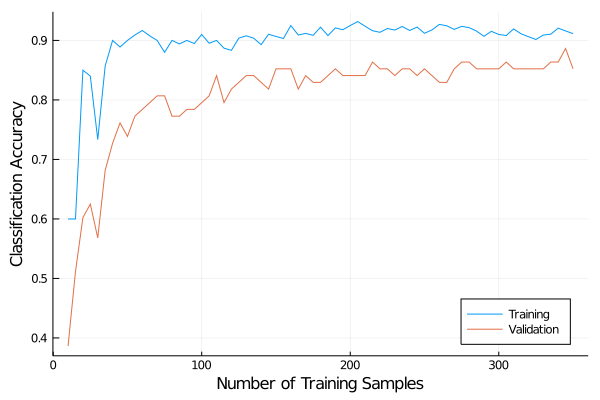

In [105]:
plot(data_schedule, training_losses, label="Training", legend=:bottomright)
plot!(data_schedule, valid_losses, label="Validation")
xlabel!("Number of Training Samples")
ylabel!("Classification Accuracy")

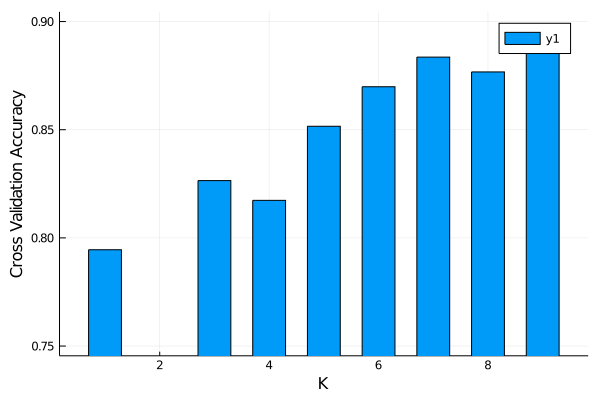

In [106]:
bar(self_tuning_knn.report.plotting.parameter_values[:,1], 
    self_tuning_knn.report.plotting.measurements,
    bar_width=0.6,
    ylims=[0.75, 0.9])
    fillcolor=:red
    fillalpha=0.2
xlabel!("K")
ylabel!("Cross Validation Accuracy")

# Final Results

In [107]:
knn_final = KNNClassifier(K=best.best_model.K)

KNNClassifier(
    K = 9,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @377

In [108]:
KNN_Final = machine(knn_final, X, y)

Machine{KNNClassifier} @557 trained 0 times.
  args: 
    1:	Source @357 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @368 ⏎ `AbstractArray{Multiclass{3},1}`


In [109]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @776.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{KNNClassifier} @776 trained 8 times.
  args: 
    1:	Source @859 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @184 ⏎ `AbstractArray{Multiclass{3},1}`


In [110]:
ŷ = MLJ.predict(KNN, X[test,:]);

In [111]:
cross_entropy(ŷ, y[test]) |> mean

1.4481250610488916

In [112]:
acc(ŷ, y[test])

0.8288770053475936

In [113]:
c = confusion_matrix(mode.(ŷ), y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["B", "L", "R"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │      B      │      L      │      R      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      B      │      2      │      5      │      2      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      L      │     11      │     78      │      9      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      R      │      2      │      3      │     75      │
└─────────────┴─────────────┴─────────────┴─────────────┘


In [129]:
(11+2)/(11+2+2)

0.8666666666666667

In [130]:
(5+3)/(5+3+78)

0.09302325581395349

In [131]:
(2+9)/(2+9+75)

0.12790697674418605

In [115]:
misclassification_rate(c)

0.17112299465240643